# Analyse des tendances des publications scientifiques dans le domaine de l'économétrie en 2023

### Théo Bouédo                                        


# Importation des bibliothèques 

In [1]:
import pandas as pd 
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.parsing.preprocessing import STOPWORDS
import nltk; nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
import requests
import numpy as np
import seaborn as sns


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


/Users/theo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
[nltk_data] Downloading package wordnet to /Users/theo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/theo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/theo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/theo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Récupération des données avec l'API OPENALEX 
(temps de requête 10minutes)

In [4]:
# URL de base pour les requêtes API, incluant des paramètres pour filtrer par concept et année de publication, et paginer les résultats
url_base_avec_curseur = 'https://api.openalex.org/works?filter=concepts.id:C149782125,publication_year:2023&per-page=200&cursor={}'

cursor = '*'  # Initialise le curseur à '*' pour la première requête

data_list = []  # Crée une liste vide pour stocker les données extraites

while cursor:  # Boucle tant qu'un curseur est présent
    url = url_base_avec_curseur.format(cursor)  # Formate l'URL avec le curseur actuel
    response = requests.get(url).json()  # Fait la requête à l'API et convertit la réponse en JSON
    works = response['results']  # Extrait les résultats de la réponse
    
    for work in works:  # Itère sur chaque "travail" retourné par l'API
        # Liste les noms des auteurs, utilisant 'Anonyme' si aucun nom n'est disponible
        authors_names = [author.get('display_name', 'Anonyme') for author in work.get('authorships', [])]
        # Liste les mots-clés de l'abstract, ou indique si non disponible
        abstract_words = list(work.get('abstract_inverted_index', {}).keys()) if work.get('abstract_inverted_index') else ['Abstract non disponible']
        # Extrait la langue de la publication, ou indique si non disponible
        language = work.get('language', 'Langue non disponible')
        # Ajoute les données extraites dans data_list sous forme de dictionnaire
        data_list.append({
            'title': work['title'],
            'year': work['publication_year'],
            'doi': work['doi'],
            'abstract_keywords': ", ".join(abstract_words),
            'language': language
        })
    
    # Met à jour le curseur avec le suivant, ou None si fini
    cursor = response['meta'].get('next_cursor', None)

df = pd.DataFrame(data_list)  # Crée un DataFrame Pandas à partir de data_list


# Traitement des données

In [2]:
# Chargement du dataframe
df = pd.read_csv("donnees_econometrics_2023.csv")

# Filtrer pour garder uniquement les lignes où "language" est "english"
df = df[df['language'].str.lower() == 'en']

# Fonction de prétraitement des données textuelles
def preprocess_text(text):
    # Conversion en minuscules
    text = text.lower()
    # Suppression de la ponctuation et des nombres
    text = re.sub(r'[\d]', ' ', text)  # Supprime les chiffres
    text = re.sub(r'[^\w\s]', ' ', text)  # Supprime la ponctuation
    # Tokenisation
    tokens = word_tokenize(text)
    # Suppression des stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    # Lemmatisation
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    # Retourner les tokens nettoyés sauf si "abstract non disponible" est détecté
    return ' '.join(lemmatized_tokens) if "abstract non disponible" not in text else ''

# Appliquer le prétraitement aux mots-clés
df['processed_keywords'] = df['abstract_keywords'].astype(str).apply(preprocess_text)

# Supprimer les entrées où 'processed_keywords' est vide après prétraitement
df = df[df['processed_keywords'] != '']

# Echantillonnage 

Afin de réduire les coûts des calculs nous allons prendre un échantillon de 5000 papiers. Ceci est necessaire pour l'utilisation de Berth.

In [5]:
#df = df.sample(5000)
#df.to_csv("df.csv")

In [3]:
df = pd.read_csv("df.csv")

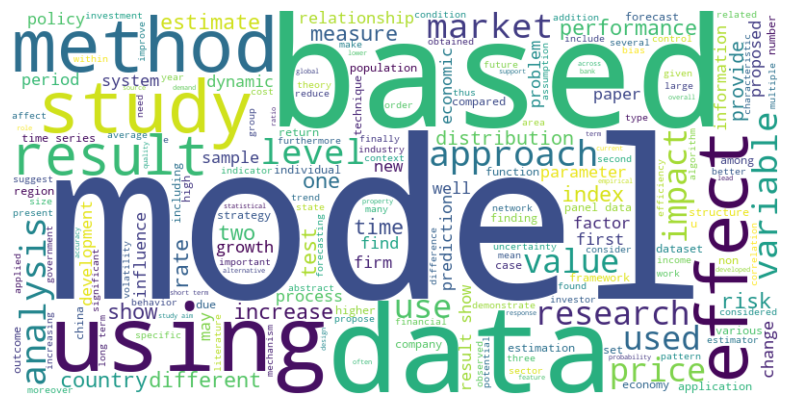

         Word  Frequency
187     model       5214
14       data       3571
317     study       3454
44     result       3022
535    effect       2441
259    method       2390
546     using       2274
38   analysis       2264
892     based       1987
124  variable       1725


In [4]:
# Génération d'un nuage de mots pour visualiser les mots-clés les plus fréquents
def generate_word_cloud(text_series):
    text = ' '.join(text_series)
    wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Visualisation des mots-clés les plus fréquents
generate_word_cloud(df['processed_keywords'])

# Analyse de la fréquence des mots
def word_frequency(text_series):
    all_words = ' '.join(text_series).split()
    freq_dist = nltk.FreqDist(all_words)
    return pd.DataFrame(freq_dist.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Afficher les 10 mots les plus fréquents
freq_df = word_frequency(df['processed_keywords'])
print(freq_df.head(10))


# LDA

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Fonction pour vectoriser les données textuelles en utilisant TF-IDF avec n-grams
def tfidf_vectorization(text_data, ngram_range=(1, 2), max_features=1000):
    vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features)
    tfidf_matrix = vectorizer.fit_transform(text_data)
    return tfidf_matrix, vectorizer

# Application de la vectorisation TF-IDF sur les mots-clés prétraités
tfidf_matrix, tfidf_vectorizer = tfidf_vectorization(df['processed_keywords'])

# Fonction pour appliquer le modèle LDA à la matrice TF-IDF
def apply_lda(tfidf_matrix, n_topics=3, max_iter=5):
    lda_model = LatentDirichletAllocation(n_components=n_topics, max_iter=max_iter, learning_method='online', random_state=0)
    lda_model.fit(tfidf_matrix)
    return lda_model

# Ajustement du modèle LDA
lda_model = apply_lda(tfidf_matrix, n_topics=3)

# Fonction pour afficher les topics générés par le modèle LDA
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Affichage des 10 premiers mots de chaque topic
display_topics(lda_model, tfidf_vectorizer.get_feature_names_out(), 15)

# Obtenir la distribution des topics pour chaque document
topic_distribution = lda_model.transform(tfidf_matrix)

# Attribuer à chaque document le topic principal (celui ayant la plus haute proportion)
df['topic'] = np.argmax(topic_distribution, axis=1)

Topic 0:
country effect growth panel study impact economic policy firm relationship development finding result level economy
Topic 1:
price stock market return asset volatility company forecasting forecast financial model investor portfolio exchange ratio
Topic 2:
model method data distribution time based approach estimate parameter study proposed paper two function process


/var/folders/2_/bx3pgkjx0rjgw6t2ywz8y00c0000gn/T/ipykernel_29685/2487038583.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=topic_counts.index, y=topic_percentage.values, palette="viridis")


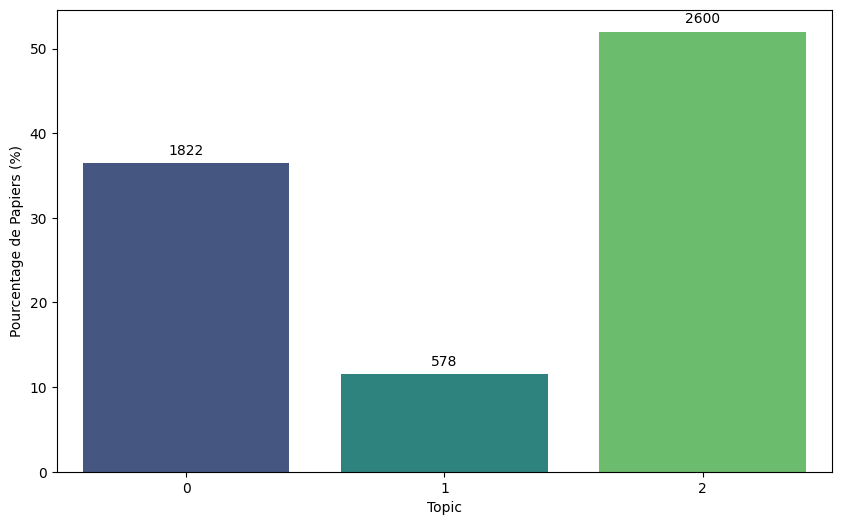

In [6]:
# Calculer le nombre total de documents par topic
topic_counts = df['topic'].value_counts().sort_index()

# Calculer les pourcentages
topic_percentage = (topic_counts / df['topic'].count() * 100)

import matplotlib.pyplot as plt
import seaborn as sns

# Créer le bar plot
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=topic_counts.index, y=topic_percentage.values, palette="viridis")

# Ajouter les étiquettes avec le nombre absolu sur chaque barre
for idx, p in enumerate(barplot.patches):
    barplot.annotate(str(topic_counts.iloc[idx]), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', 
                     xytext=(0, 9), 
                     textcoords='offset points')

plt.xlabel('Topic')
plt.ylabel('Pourcentage de Papiers (%)')
plt.show()


          Topic 0   Topic 1   Topic 2
Topic 0  1.000000 -0.274093 -0.813695
Topic 1 -0.274093  1.000000 -0.336003
Topic 2 -0.813695 -0.336003  1.000000


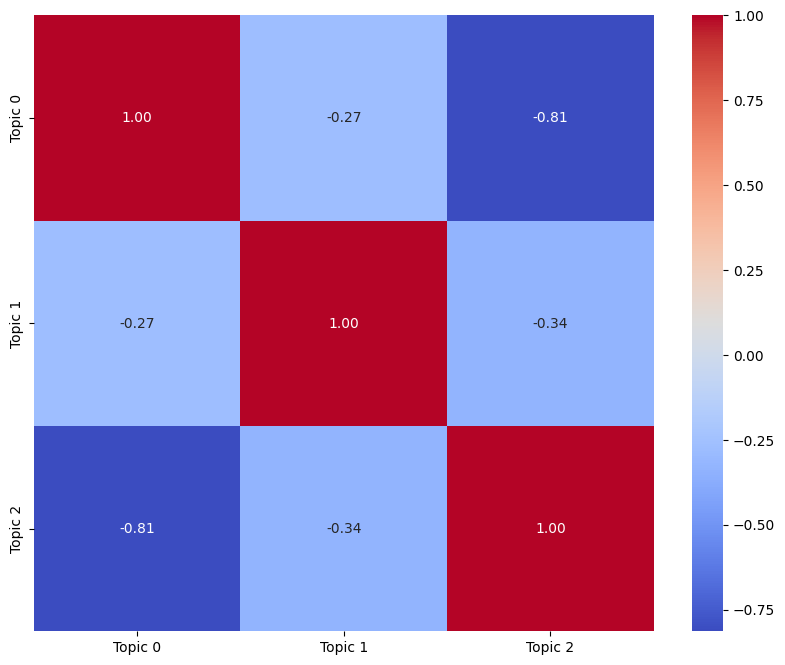

In [7]:
topic_distribution = lda_model.transform(tfidf_matrix)


# Calculer la matrice de corrélation
topic_correlation = np.corrcoef(topic_distribution.T) 
topic_correlation_df = pd.DataFrame(topic_correlation)

# Nommer les colonnes et les index pour plus de clarté
topic_labels = [f"Topic {i}" for i in range(topic_distribution.shape[1])]
topic_correlation_df.columns = topic_labels
topic_correlation_df.index = topic_labels

# Afficher la matrice de corrélation
print(topic_correlation_df)

# Visualiser la matrice de corrélation avec une heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(topic_correlation_df, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()


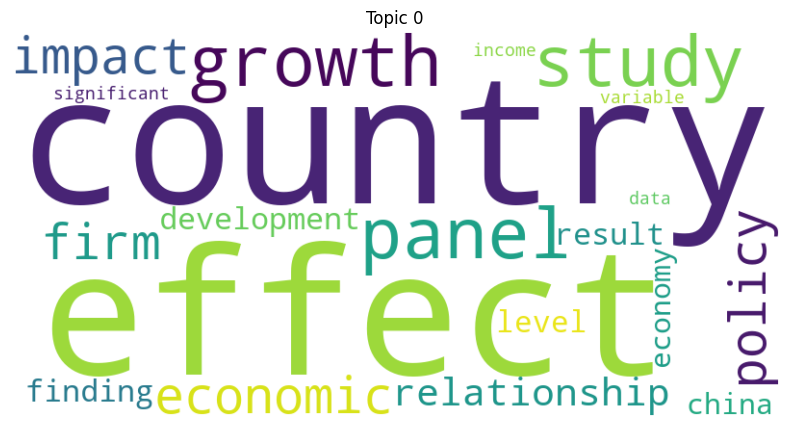

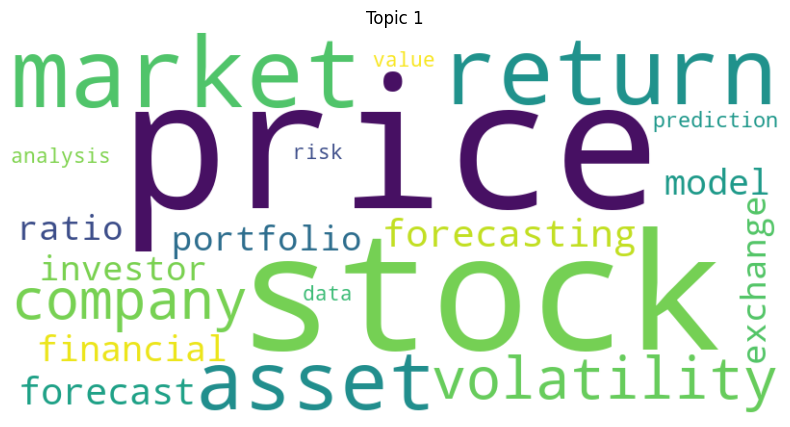

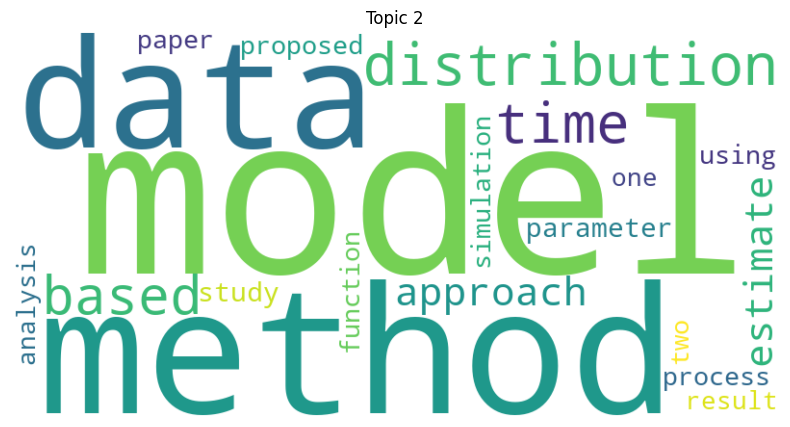

In [135]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Fonction pour générer un nuage de mots pour chaque topic
def generate_word_clouds(model, feature_names, n_topics, n_words=20):
    for topic_idx in range(n_topics):
        # Trier les indices des mots selon leur importance dans le topic
        top_features_ind = model.components_[topic_idx].argsort()[:-n_words - 1:-1]
        # Créer un dictionnaire des mots et de leurs poids
        top_features = {feature_names[i]: model.components_[topic_idx, i] for i in top_features_ind}
        # Générer le nuage de mots
        wordcloud = WordCloud(width=800, height=400, background_color='white')
        wordcloud.generate_from_frequencies(top_features)
        # Affichage
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(f'Topic {topic_idx}')
        plt.show()

# Obtenir les noms des caractéristiques (mots) du vectoriseur TF-IDF
feature_names = tfidf_vectorizer.get_feature_names_out()

# Appeler la fonction pour générer des nuages de mots pour chaque topic
generate_word_clouds(lda_model, feature_names, lda_model.n_components)


## Analyse sémantique avancée

Étape 1: Génération des Embeddings BERT pour les Mots Clés


In [11]:
from transformers import BertTokenizer, BertModel
import torch

topic_keywords = df.groupby('topic')['processed_keywords'].apply(lambda docs: ' '.join(docs)).tolist()


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)

def get_bert_embeddings(text):
    encoded_input = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        output = model(**encoded_input)
    return output.pooler_output.squeeze(0)  

topic_embeddings = {i: get_bert_embeddings(text) for i, text in enumerate(topic_keywords)}


Étape 2: Analyse des Relations Inter-Topics


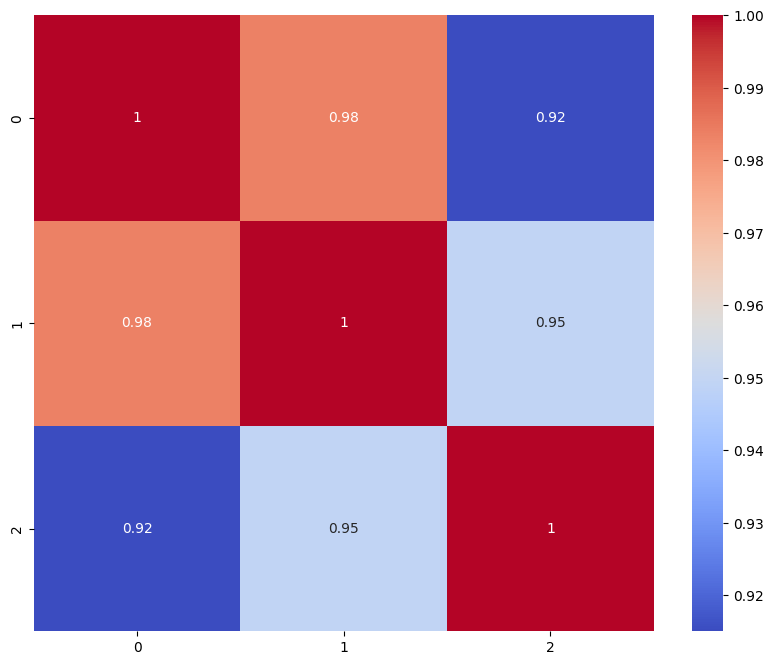

In [26]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Créer une matrice d'embeddings
embeddings_matrix = torch.stack(list(topic_embeddings.values())).numpy()

# Calculer la similarité cosinus entre les topics
similarity_matrix = cosine_similarity(embeddings_matrix)

# Visualiser la matrice de similarité

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm')
plt.show()

# Création graph de co-occurence

In [19]:
def display_top_words(model, feature_names, no_top_words):
    top_words_per_topic = {}
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        top_words_per_topic[topic_idx] = top_words
    return top_words_per_topic

# Nombre de mots par topic
no_top_words = 15

# Récupération des top mots pour chaque topic
top_words_per_topic = display_top_words(lda_model, tfidf_vectorizer.get_feature_names_out(), no_top_words)


In [20]:
from sklearn.feature_extraction.text import CountVectorizer

# Fusionner les mots clés dans une liste unique pour vectorisation
unique_words = list(set(word for words in top_words_per_topic.values() for word in words))

# Créer une matrice de co-occurrence
vectorizer = CountVectorizer(vocabulary=unique_words)
co_occurrence_matrix = (vectorizer.fit_transform(df['processed_keywords']).T * vectorizer.fit_transform(df['processed_keywords']))

# Transformer en array numpy pour manipulation facile
co_occurrence_matrix = co_occurrence_matrix.toarray()


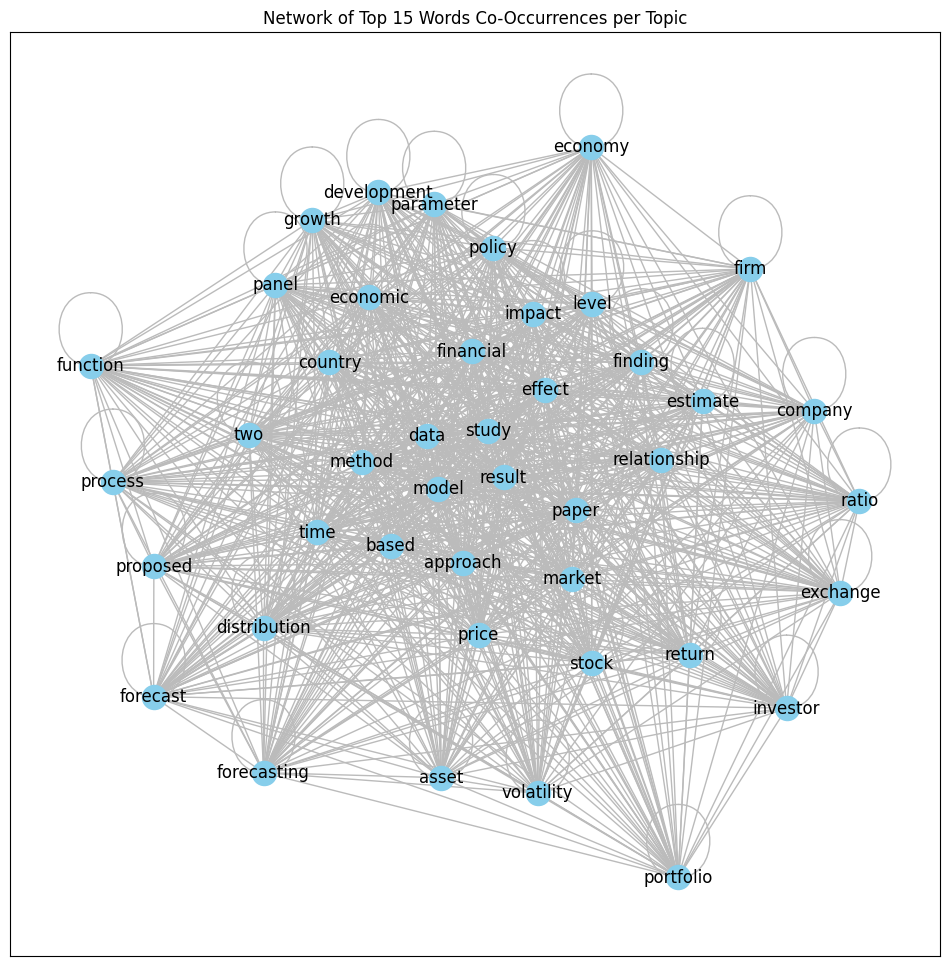

In [21]:
G = nx.from_numpy_array(co_occurrence_matrix)
mapping = {node: unique_words[node] for node in range(len(unique_words))}
G = nx.relabel_nodes(G, mapping)

# Filtrer pour enlever les arêtes avec peu de co-occurrences
threshold = 2  # Seuil minimal d'occurrence pour afficher une arête
edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] < threshold]
G.remove_edges_from(edges_to_remove)

# Visualisation
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=1)  # k contrôle la distance entre les nœuds
nx.draw_networkx(G, pos, with_labels=True, node_color='skyblue', edge_color="#BBBBBB")
plt.title("Network of Top 15 Words Co-Occurrences per Topic")
plt.show()


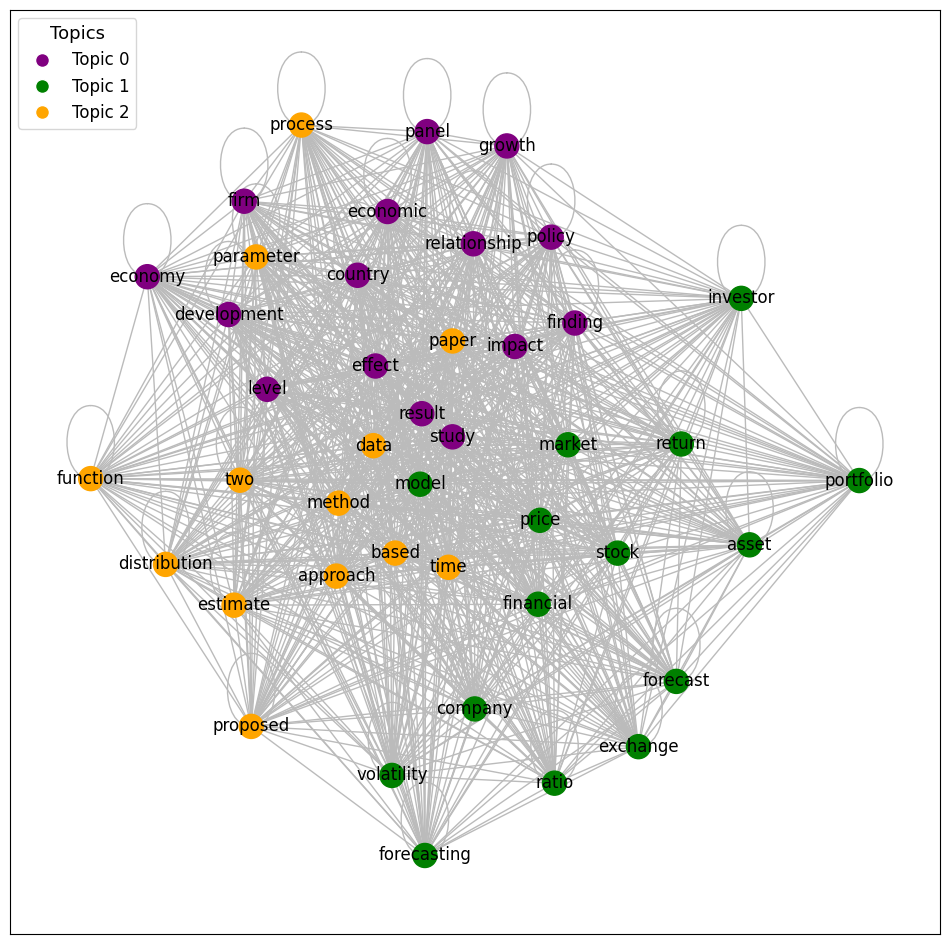

In [25]:
topic_colors = {
    0: 'purple',      # Couleur pour le topic 0
    1: 'green',     # Couleur pour le topic 1
    2: 'orange',    # Couleur pour le topic 2
}

node_colors = []
for node in G.nodes():
    for topic, words in top_words_per_topic.items():
        if node in words:
            node_colors.append(topic_colors[topic])
            break

plt.figure(figsize=(12, 12))
# Ajout de la légende
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f'Topic {i}')
                  for i, color in topic_colors.items()]
plt.legend(handles=legend_handles, title="Topics", title_fontsize='13', loc='upper left', fontsize='12')
pos = nx.spring_layout(G, k=1)  # k contrôle la distance entre les nœuds
nx.draw_networkx(G, pos, node_color=node_colors, with_labels=True, edge_color="#BBBBBB")
plt.show()
